## Example 5: Extractive Distillation

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interactive, Button, VBox, HBox, Output

from utils import AntoineEquationBaseE
from distillation import DistillationModelDoubleFeed 
from distillation import DistillationModelTernary 

from thermo_models import VanLaarModel
from distillation import PhasePortraits

plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})

In [8]:
#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Knapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine  = AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine    = AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325 # Provide pressure in pascals
# Specify property method for Acetone Methanol Water system
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

In [9]:
# Define plot functions
def plot_mb(dist_model):
    
    fig, ax = plt.subplots(figsize= (6,5))
    dist_model.plot_mb(ax)
    plt.tight_layout()
    plt.show()
    
    
# Create an interactive plot function
def plot_middle(dist_model, rc, rr, Fr, middle_start):
    
    reset_column(dist_model, Fr = Fr, R = rr)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    dist_model.plot_rect_strip_comp(ax[0], middle_start=middle_start)
    dist_model.plot_middle_comp(ax[1], middle_start=middle_start)
    rc.plot_vector_field_middle(ax[1])
    plt.tight_layout()
    plt.show()
      

In [10]:
# Create slider objects
R1_slider = widgets.FloatSlider(value=3, min=1, max=200.0, step=0.1,  description='Reflux Ratio:', readout_format='.1f')
R2_slider = widgets.FloatSlider(value=1, min=0.05, max=50, step=0.05,  description='Reflux Ratio:', readout_format='.2f')
Fr_slider = widgets.FloatSlider(value=1, min=0.05, max=3, step=0.05,  description='Feed Ratio:', readout_format='.2f')

In [11]:
Fr  = 1  # Feed ratio
R   = 2  # reflux ratio
xFL = np.array([0.4, 0.6, 0])
xFU = np.array([1e-5, 0.001 - 1e-5, 0.999])
zF  = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                               #Knapp Equation 5.9
xD  = np.array([0.99, 0.009, 0.001]) 
D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
xB  = np.array([(zF[0] - D_B*(xD[0]-zF[0])), (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

#### Create distillation models

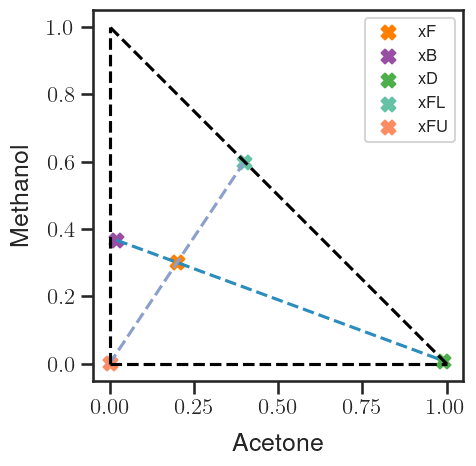

In [12]:
def reset_column(dist_model, Fr = 1, R = 2):
    
    xFL = np.array([0.4, 0.6, 0])
    xFU = np.array([1e-5, 0.001 - 1e-5, 0.999])
    zF  = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                               #Knapp Equation 5.9
    xD  = np.array([0.99, 0.009, 0.001])
    D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
    xB  = np.array([(zF[0] - D_B*(xD[0]-zF[0])), (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

    dist_model.set_Fr(Fr)
    dist_model.set_r(R)
    dist_model.set_xFL(xFL)
    dist_model.set_xFU(xFU)
    dist_model.set_xD(xD)
    dist_model.set_zF(zF)
    dist_model.set_xB(xB)

# Distillation model object
distillation_model_DF = DistillationModelDoubleFeed(thermo_model=AceMethWaterSys, Fr = 1, zF = np.array([0.200005, 0.300495, 0.4995]) , xFL = np.array([0.4, 0.6, 0]), xFU = np.array([1e-5, 0.001 - 1e-5, 0.999]), xD = np.array([0.99, 0.009, 0.001]), xB = np.array([0.02,0.36691385, 0.49938619]), reflux = 2)

# Distillation single feed object
distillation_model_SF = DistillationModelTernary(AceMethWaterSys, xF = np.array([0.200005, 0.300495, 0.4995]), xD = np.array([0.99, 0.009, 0.001]), xB = np.array([0.02,0.36691385, 0.49938619]), reflux = 2)

reset_column(distillation_model_DF)

# Residue curve map object
rcm_DF = PhasePortraits(thermo_model=AceMethWaterSys, distil_model = distillation_model_DF)
rcm_SF = PhasePortraits(thermo_model=AceMethWaterSys, distil_model = distillation_model_SF)

plot_mb(distillation_model_DF)

### Why not use a single feed distillation column for this separation ?

The rectifying and stripping operating lines together with their phase potraits are provided below. No matter what the reflux ratio is, you will not be able to case a situation where the stripping OL overlaps with the rectifying OL.

In [13]:
out      = Output()

def plot_rect_strip(dist_model, rcm, rr):
    
    dist_model.set_r(rr)
    
    fig, ax = plt.subplots(1,3,figsize= (15,5))
    dist_model.plot_rect_strip_comp(ax[0])   
    
    rcm.plot_vector_field_rect  (ax[1], 20)
    rcm.plot_vector_field_strip (ax[2], 20)
    
    dist_model.plot_rect_comp  (ax[1])
    dist_model.plot_strip_comp (ax[2])

    plt.tight_layout()
    plt.show()
    
    
def on_go2_button_click(b):
    
    with out:
        clear_output()
        plt.close('all')  # Close all open matplotlib plots
        plot_rect_strip( distillation_model_SF, rcm_SF, rr = R1_slider.value)
        
go2_button = widgets.Button(description='Generate Plot')
go2_button.on_click(on_go2_button_click)

layout = VBox([HBox([R1_slider, go2_button]), out])
display(layout)

### A feasible design for a double feed distillation column

In the double feed column case there are three operating lines (i) rectifying (ii) stripping and (iii) middle section. The middle section line starts at the stage where the solvent (entrainer) is fed. The stripping stage begins where the feed mixture to be distilled is fed.

In order for a column to be feasible we need a continuous path via these operating lines from the distillate to the bottoms composition. First let us look at a feasible column design. Notice how the middle section OL  acts as a staple that connects the rectifying and stripping sections.  

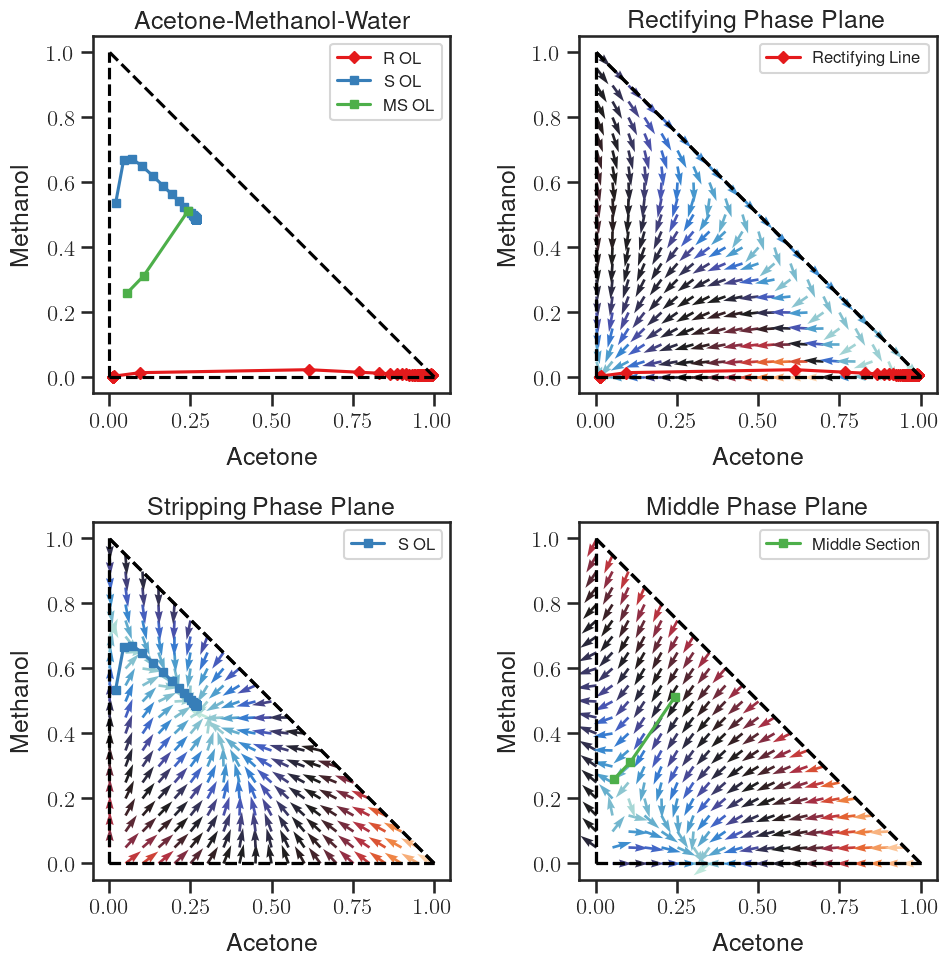

In [16]:
dist_model = distillation_model_DF
rc         = rcm_DF

reset_column(dist_model, 0.5, 2.5)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

dist_model.plot_rect_strip_comp(axes[0,0], middle_start=10)
dist_model.plot_rect_comp  (axes[0,1])
dist_model.plot_strip_comp  (axes[1,0])
dist_model.plot_middle_comp  (axes[1,1], middle_start=10)

rc.plot_vector_field_rect(axes[0,1]) 
rc.plot_vector_field_strip(axes[1,0])
rc.plot_vector_field_middle(axes[1,1])

axes[0,0].set_title('Acetone-Methanol-Water')

plt.tight_layout()
plt.show()

### Demo 2: How does the location of the solvent feed stage affect feasibility

The solvent feed stage location is a critical parameter. Notice how the middle section correctly acts as a staple that connects the rectifying and stripping sections for feed stage 6 and 8, but fails if feed stage is set at 2 or 4. The Middle OL Vector Field depicts how the middle operating line moves towards the rectifying operating line (red) upon changing feed stage location.

In [ ]:
# Create a dropdown widget for middle_start
out = Output()
reset_column(distillation_model_DF, 1, 3)
middle_start_widget = widgets.Dropdown(options=[2, 4, 6, 8], description='Middle Section Start:', disabled=False)
    
def on_go_button_click(b):
    with out:
        clear_output()
        plt.close('all')  # Close all open matplotlib plots
        plot_middle(distillation_model_DF, rcm_DF, rr = 3, Fr = 1, middle_start = middle_start_widget.value)
                
go_button = Button(description='Generate Plot')
go_button.on_click(on_go_button_click)

layout = VBox([HBox([middle_start_widget, go_button]), out])
display(layout)

### Increasing reflux ratio does not always help

**Keep increasing the reflux ratio.** 

* **What happens when R < 2.5 ?**

* **What happens around R = 45 ?**

You'll notice that the landscape of the MS OL has changed and it no longer acts as a staple.

In [ ]:
out_rr = Output()

def on_go_button_click(b):
    with out_rr:
        clear_output()
        plt.close('all')  # Close all open matplotlib plots
        plot_middle(distillation_model_DF, rcm_DF, rr = R2_slider.value, Fr = 0.25, middle_start = 10)
        
go_button = Button(description='Generate Plot')
go_button.on_click(on_go_button_click)

layout = VBox([HBox([R2_slider, go_button]), out_rr])
display(layout)

### How does changing feed ratio affect feasibility of separation ?

Check what happens when feed ratio falls below 0.5.

In [ ]:
out_Fr = Output()

def on_go_button_click(b):
    with out_Fr:
        clear_output()
        plt.close('all')  # Close all open matplotlib plots
        plot_middle(distillation_model_DF, rcm_DF, rr = 3, Fr = Fr_slider.value, middle_start = 6)
        
go_button = Button(description='Generate Plot')
go_button.on_click(on_go_button_click)

layout = VBox([HBox([Fr_slider, go_button]), out_Fr])
display(layout)